# Store item demand forecasting
In this project, I will build a machine learning model to forecast 3 months of 50 items sales in 10 different stores of a company. It involves supervised learning, using a labeled training set for time series forecasting.

I will use the following pipeline, based on CRISP-DM framework:

1. Business understanding
2. Data understanding
3. Data preparation
4. Modelling
5. Evaluation
6. Deployment

In this notebook, I will be covering steps 3 to 6 of the pipeline above. The main objective here is to build a model capable of accurately forecasting sales for 50 items across 10 stores over a three-month period, interpreting its outcomes and determining financial results. Furthermore, I will approach these steps in detail below, explaining why I am making each decision.

### Importing the libraries

In [58]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor

# Warnings filtering.
import warnings
warnings.filterwarnings('ignore')

# Plot grid styles.
sns.set_theme(style='whitegrid')

### Reading the dataset

In [44]:
df_raw = pd.read_csv('data/train.csv')

In [45]:
df_raw.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


I will convert the date column to the correct data type (datetime) and set it as the dataset index in order to turn the modelling step easier. In a forecasting task, the date column is very important. From the dates, other time series features will be created and we will be able to visualize the sales trends, seasonal patterns and characteristics over time. Another common practice is to set the date as the dataset index, and I will also do that.

In [46]:
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw.set_index('date', inplace=True)
df_raw.sort_values(by=['date', 'store', 'item'], inplace=True)
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11


In [47]:
print(f'The data goes from {df_raw.index.min()} to {df_raw.index.max()}.')

The data goes from 2013-01-01 00:00:00 to 2017-12-31 00:00:00.


Now, based on CRISP-DM framework, I will start to perform feature engineering / data preparation and modelling. From the framework, we can turn back to the data preparation step after modelling and vice-versa. I will do this, since I intend to start with a baseline model constructed with more simple feature engineering and keep testing different approaches until the best performance is achieved.

# 4. Data preparation
- In this step, I will do all the data preparation, like feature engineering, train-test split and data preprocessing. 
- I will be turning back to this phase after modelling in order to test different approaches (from simpler to more complex ones) until the best performance is achieved in a crisp-dm data preparation / modelling cycle. Thus, I will enumerate the distinct data preparations and modelling approaches I will test.
- I intend to use LightGBM for the sales forecasting because I am focusing on the predictive power. LightGBM offers fast training and high predictive power by using the gradient boosting trees framework. Furthermore, with its early stopping parameter, it is possible to avoid overfitting by stopping the training when the validation error stops to decrease while the training error continues decreasing. This is the moment where overfitting starts.
- Tree-based models like LightGBM don't require feature scaling. Thus, I will not scale the data.
- Time series features like dayofweek and weeokfyear already present ordinal relationships, allowing the ensembles to capture seasonality and so on. Thus, it may not be an advantage encoding them. One-hot encoding, for example, would damage trees performance due to sparse representation and dimensionality increase. Moreover, although they are in numeric data type, features like store and item present categorical behaviour and could be encoded. 
- Considering everything mentioned above, initially, I don't intend to perform any transformation to these features. However, I will test different approaches, turning back to data preparation after modelling, in a crisp-dm data preparation / modelling cycle.
- LightGBM already deals with missing values, so, when creating features like lags, I will not treat them.
- The outliers were investigated in the EDA step. Once they don't represent iconsistent information, I will not treat them.
- For time series forecasting, a bunch of features can be created, including lag features, rolling statistics, date-related features, holiday indicators, time-based aggregations and so on. I will test them below.
- Considering that sales variable is significantly right-skewed, a log-transformation can be applied to normalize it, turning it more symmetric. Again, I will test different approaches below, including this one.

Once I will test different data preparation and modelling approaches, I will create a function that splits the data in predictor and target train and test sets for us in order to turn this task faster. The split will follow a chronological order, once I am dealing with a time series task.

In [92]:
def time_series_split(data, target, cutoff_date):

    train = data.loc[data.index < cutoff_date]
    test = data.loc[data.index >= cutoff_date]
    
    X_train = train.drop(columns=[target])
    y_train = train[target].copy()
    X_test = test.drop(columns=[target])
    y_test = test[target].copy()

    return train, test, X_train, X_test, y_train, y_test

### 1.0 Baseline
Below I will start with a baseline data preparation and modelling. Then, I will try to enhance this baseline model performance in a crisp-dm data preparation / modelling cycle.

### 1.1 Basic feature engineering
Initially, let's create basic time series features. 

In [49]:
def feature_engineering(data):
    
    df = data.copy()
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(np.float64)
    df['is_wknd'] = df.index.weekday // 4
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)

    return df

In [50]:
df = feature_engineering(df_raw)
df.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,2,33,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,3,15,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,4,10,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,5,11,1,1,1,2013,1,1,1.0,0,1,0


### 1.2 Time series train-test-split
I will split the data into train and test sets. Test set is supposed to be data the model has never seen before. Once the objective is to predict 3 months of item demand, I will separate 3 months of data for the test. An important observation here is that I will divide the data chronologically, using earlier data for training and later data for testing, ensuring the model predicts future events. Randomly splitting the data would lead to data leakage.

In [96]:
cutoff_date = '2017-09-30'
train, test, X_train, X_test, y_train, y_test = time_series_split(df, target='sales', cutoff_date=cutoff_date)

In [95]:
print(f'Train shape: {train.shape}. Train data goes from {train.index.min()} to {train.index.max()}.')
print(f'Test shape: {test.shape}. Train data goes from {test.index.min()} to {test.index.max()}.')
print(f'Train predictor and target sets shapes: {X_train.shape}, {y_train.shape}')
print(f'Test predictor and target sets shapes: {X_test.shape}, {y_test.shape}')

Train shape: (866500, 13). Train data goes from 2013-01-01 00:00:00 to 2017-09-29 00:00:00.
Test shape: (46500, 13). Train data goes from 2017-09-30 00:00:00 to 2017-12-31 00:00:00.
Train predictor and target sets shapes: (866500, 12), (866500,)
Test predictor and target sets shapes: (46500, 12), (46500,)


Let's visualize the time series train-test-split.

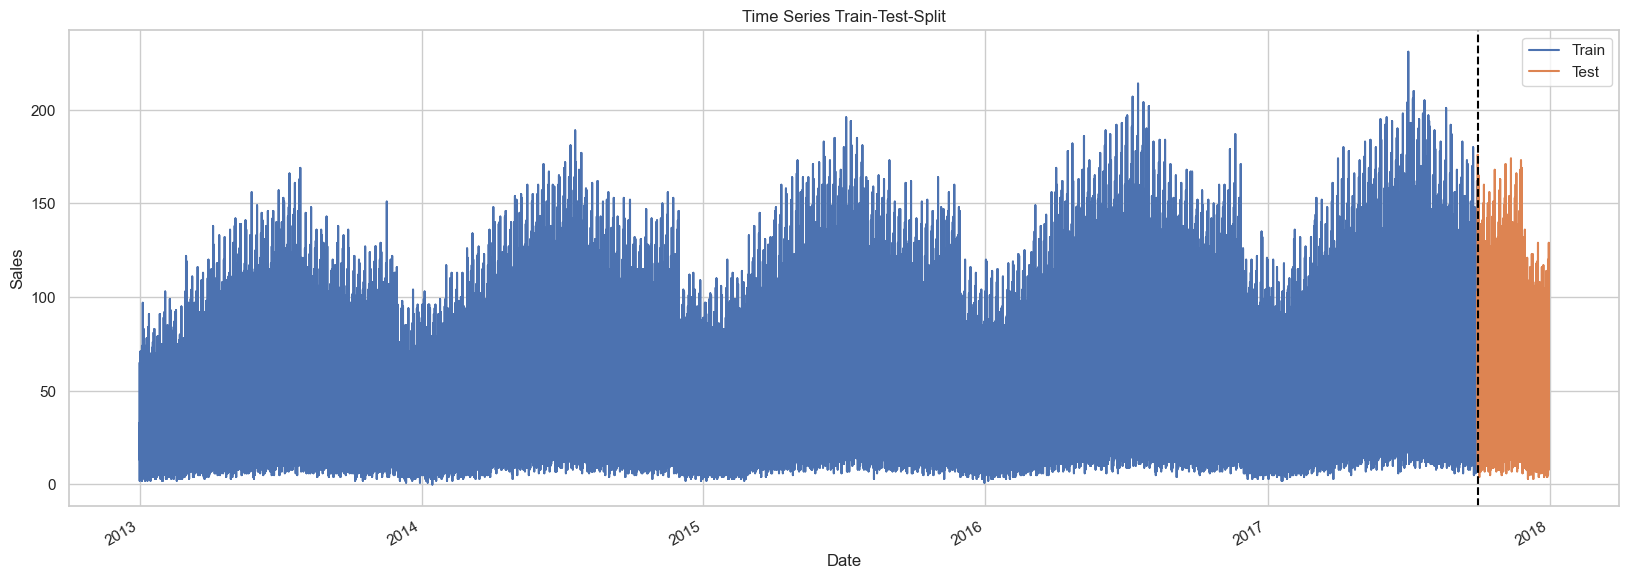

In [53]:
figure, ax = plt.subplots(figsize=(20, 7))

train.plot(ax=ax, label='Train', y='sales')
test.plot(ax=ax, label='Test', y='sales')

ax.axvline('2017-09-30', color='black', ls='--')

plt.title('Time Series Train-Test-Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### 2.0 Log Transformation
Considering that sales variable is significantly right-skewed (I found this on EDA step), I will apply a log transformation to it in order to turn it more symmetric. By doing this, the model will better capture the patterns behind the data. An important observation here is that there are records with zero sales. Thus, I will add a constant (1) to the log transformation.

In [105]:
df_log = df_raw.copy()
df_log['sales'] = np.log1p(df_log['sales'])
df_log = feature_engineering(df_log)
train_log, test_log, X_train_log, X_test_log, y_train_log, y_test_log = time_series_split(df_log, 'sales', cutoff_date)
df_log.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,0,1,0


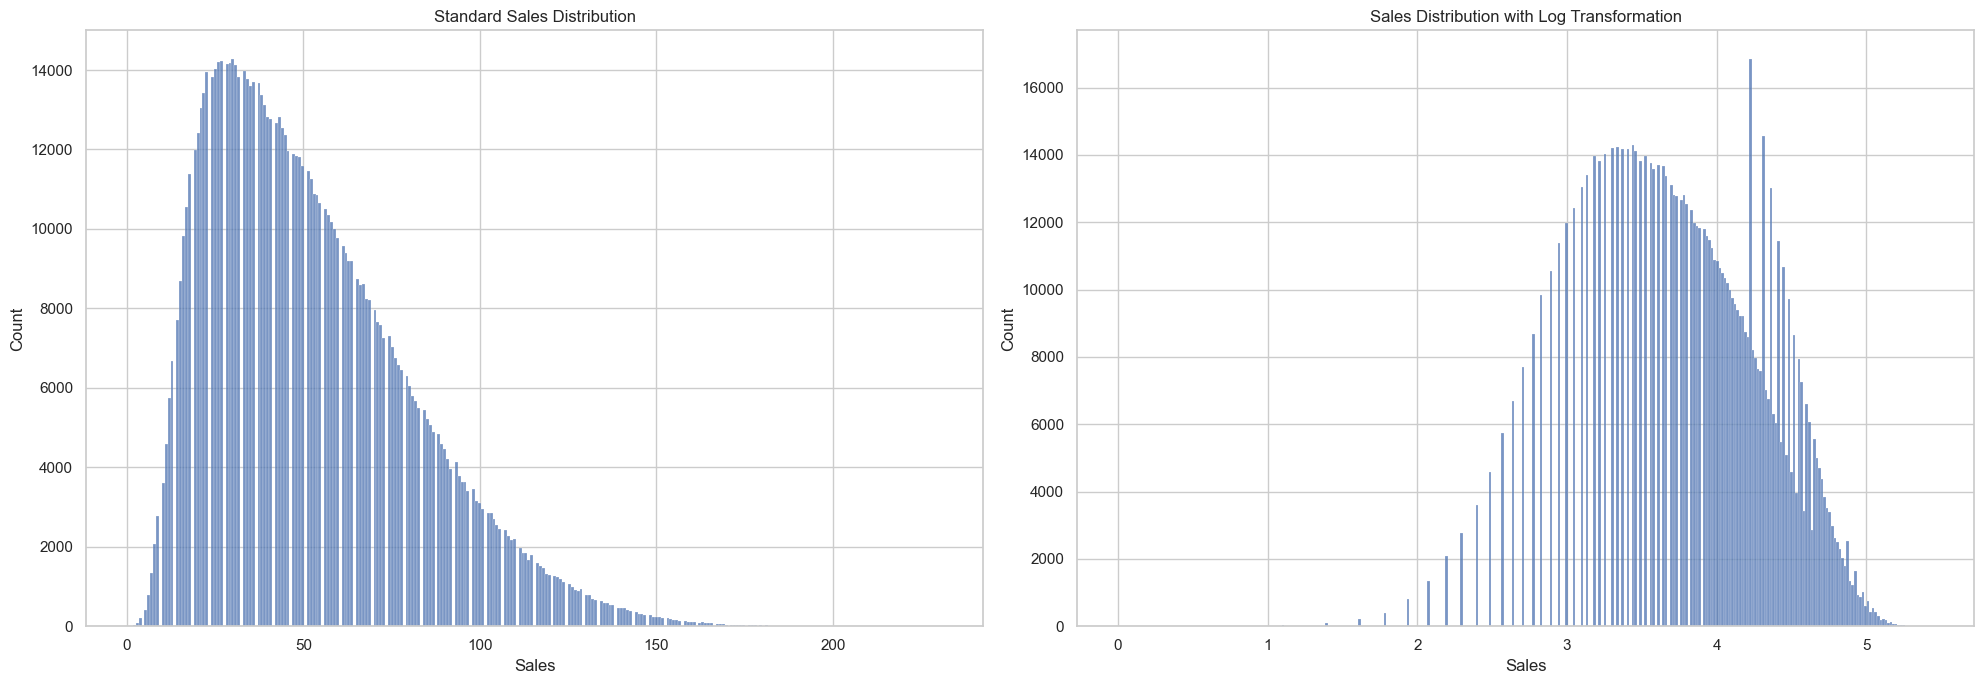

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax0 = sns.histplot(data=df_raw, x='sales', ax=ax[0])
ax0.set_title('Standard Sales Distribution')
ax0.set_xlabel('Sales')
ax0.set_ylabel('Count')

ax1 = sns.histplot(data=df_log, x='sales', ax=ax[1])
ax1.set_title('Sales Distribution with Log Transformation')
ax1.set_xlabel('Sales')
ax1.set_ylabel('Count')

plt.tight_layout()
plt.show()

By applying log transformation to sales variable, its distribution becomes more symmetric, allowing the model to better capture the patterns behind the data.

# 5. Modelling
- In this step, I will train LightGBM model with the prepared data. Different preparation and modelling approaches will be tried here and I will stick with the best one.
- First, I will try a baseline LigthtGBM model in standard configuration, trained on basic time series features data, comparing it to the average model. If its performance is better than the average model, machine learning is indeed suitable for the problem and I will stick with it, trying to enhance its results further.

### 1.0 Baseline Average Model
Before diving into machine learning techniques, I will assess the performance of an average model. If machine learning achieves a better result, it is suitable for this forecasting task, else our simple average prediction will compensate more.

Defining a function to evaluate the baseline solution with RMSE.

In [55]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

Average model performance.

In [56]:
avg_pred = train['sales'].mean()

print(f'Average model prediction: {avg_pred}.')
print(f'Average model performance on test set: RMSE = {round(rmse(y_test, avg_pred), 2)}')

Average model prediction: 52.111623773802656.
Average model performance on test set: RMSE = 28.7


### 1.1 Baseline LightGBM model
Now I will compare the average model performance with standard configurated LightGBM performance. If it presents a better result, machine learning is suitable for this forecasting task.

In [73]:
baseline_lgb = LGBMRegressor(verbose=-1)
baseline_lgb.fit(X_train, y_train)
baseline_lgb_pred = baseline_lgb.predict(X_test)
print(f'Baseline LightGBM model performance on test set: RMSE = {round(np.sqrt(mean_squared_error(y_test, baseline_lgb_pred)), 2)}')


Baseline LightGBM model performance on test set: RMSE = 9.08


The baseline LightGBM model performance is better than the average model performance! Thus, machine learning is indeed suitable for the forecasting task and I will keep trying to enhance this baseline LGBMRegressor result.

### 2.0 LightGBM model with log transformed data
Now, let's see if the performance was improved by applying the log transformation to sales variable.

In [103]:
log_lgb = LGBMRegressor(verbose=-1)
log_lgb.fit(X_train_log, y_train_log)
log_lgb_pred = log_lgb.predict(X_test_log)
print(f'Log LightGBM model performance on test set: RMSE = {round(np.sqrt(mean_squared_error(np.expm1(y_test_log), np.expm1(log_lgb_pred))), 2)}')

Log LightGBM model performance on test set: RMSE = 8.94


As expected, applying a log transformation to sales variable turns it more symmetric, allowing the model to better capture the patterns behind the data and improving performance. Thus, I will procceed with log transformed sales.